In [1]:
import time
import os
import random
import numpy as np     
import math

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [2]:
sys.path.append('../../../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [3]:
import elitism

In [4]:
x0,y0=7,7
dim3 = 3*x0*y0

### Finite Element Model of the Space Frame Element

In [5]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [6]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R) 

In [7]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [8]:
def total_length(coord,elcon):
    coord=np.array(coord)
    elcon=np.array(elcon)
    t_length=0
    for i in range(len(elcon)):
        l=PlaneTrussElementLength(coord[elcon[i][0]][0],\
                                    coord[elcon[i][0]][1],\
                                    coord[elcon[i][0]][2],\
                                    coord[elcon[i][1]][0],\
                                    coord[elcon[i][1]][1],\
                                    coord[elcon[i][1]][2])
        t_length+=l        
    return t_length 

In [9]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    
    K=np.ones(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))*(1e-4)
    
    
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        
        K=SpaceFrameAssemble(K, k, el[0], el[1])
        
    F = np.array(global_force)
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
    compliance = d.T @ K @ d
    
#     return d, compliance, total_length(coord,elcon)
    return d, compliance, _

In [10]:
# 10 The Space Frame Element - verification

In [11]:
d, compliance, t_length  = FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [12]:
d

array([-7.05147750e-06, -6.65367104e-08,  1.41769582e-05,  1.44778791e-06,
        1.74858420e-06,  1.13605430e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [13]:
compliance

0.0003540539387047346

In [14]:
t_length

''

### Genetic Modelling

In [15]:
# Genetic Algorithm constants:
POPULATION_SIZE = 150
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 65
HALL_OF_FAME_SIZE = 30

In [16]:
PENALTY_VALUE = 1000.0 

In [17]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [18]:
toolbox = base.Toolbox()

In [19]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [20]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [21]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [22]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 dim3)

In [23]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

<!-- ### RL model -->

In [24]:
def draw(coord, elcon, elev=45, azim=45, color='green', flip=False):
    c = np.array(coord)
    e = np.array(elcon)

    if e.size == 0:
        print("Warning: 'elcon' is empty. Nothing to draw.")
        return

    try:
        coord = c.reshape(np.max(e) + 1, 3)
    except Exception as ex:
        print(f"Error reshaping coord: {ex}")
        return

    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(111, projection='3d')

    for item in e:
        ax.plot([coord[item[0]][0], coord[item[1]][0]],
                [coord[item[0]][1], coord[item[1]][1]],
                [coord[item[0]][2], coord[item[1]][2]],
                color=color, linewidth=1, linestyle='--')

    ax.view_init(elev, azim)
    ax.set_xlim([0, max(x0,y0)])
    ax.set_ylim([0, max(x0,y0)])
    ax.set_zlim([0, max(x0,y0)]) 
    
    if flip:
        ax.set_zlim(ax.get_zlim()[::-1])
        
    plt.show()
    

In [25]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [26]:
def get_voxel_edge_pairs(volume):
    """
    Extracts node coordinates and all edge (node pair) connections
    from solid voxels in a 3D volume.

    Parameters:
        volume (ndarray): 3D binary voxel array (nx, ny, nz)

    Returns:
        node_coords (ndarray): Unique node coordinates, shape (N_nodes, 3)
        edge_pairs (list of tuple): Each edge as a (node_index_1, node_index_2)
    """
    nx, ny, nz = volume.shape

    node_map = {}
    node_coords = []
    node_id_counter = 0
    edge_pairs = set()  # use set to avoid duplicates

    # Define local edge pairs (in terms of local hexahedron corner indices)
    edge_template = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # bottom
        (4, 5), (5, 6), (6, 7), (7, 4),  # top
        (0, 4), (1, 5), (2, 6), (3, 7)   # verticals
    ]
    
    volume[0, 0, 0]=1
    volume[0, 0, nz-1]=1
    volume[nx-1, 0 , nz-1]=1
    volume[0, ny-1, nz-1]=1
    volume[nx-1, ny-1, nz-1]=1
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if volume[i, j, k] == 1:
                    # 8 corner points of the voxel
                    corners = [
                        (i  , j  , k  ),  # 0
                        (i+1, j  , k  ),  # 1
                        (i+1, j+1, k  ),  # 2
                        (i  , j+1, k  ),  # 3
                        (i  , j  , k+1),  # 4
                        (i+1, j  , k+1),  # 5
                        (i+1, j+1, k+1),  # 6
                        (i  , j+1, k+1)   # 7
                    ]

                    local_ids = []
                    for pt in corners:
                        if pt not in node_map:
                            node_map[pt] = node_id_counter
                            node_coords.append(pt)
                            node_id_counter += 1
                        local_ids.append(node_map[pt])
#                     print(local_ids)
                    # Add the 12 edges from this voxel
                    for (a, b) in edge_template:
                        n1, n2 = local_ids[a], local_ids[b]
                        edge = tuple(sorted((n1, n2)))
                        edge_pairs.add(edge)
                        
    a00 = list(range(6*(node_map[0, 0, nz-1]-1), 6*node_map[0, 0, nz-1]))
    a10 = list(range(6*(node_map[nx-1, 0 , nz-1]-1), 6*node_map[nx-1, 0 , nz-1]))
    a01 = list(range(6*(node_map[0, ny-1, nz-1]-1), 6*node_map[0, ny-1, nz-1]))
    a11 = list(range(6*(node_map[nx-1, ny-1, nz-1]-1), 6*node_map[nx-1, ny-1, nz-1]))  
    bc_ = sorted(a00 + a10 + a01 + a11)

    return np.array(node_coords), list(edge_pairs), bc_

In [27]:
# fitness calculation
def staticFEM(individual):
        
    topology = reconstruct_3d_structure(np.array(individual[:x0*y0]).reshape(x0,y0), 
                                        np.array(individual[x0*y0:2*x0*y0]).reshape(x0,y0), 
                                        np.array(individual[2*x0*y0:3*x0*y0]).reshape(x0,y0))
    coord, elcon, bc_node  = get_voxel_edge_pairs(topology)
    
    
    arr = np.array(elcon)
        
                        
    bc_val=[0]*len(bc_node)
    global_force=[0, 0, -10, 0, 0, 0] + list([0 for i in range(6*(np.max(arr)+1)-6)])

    try:
        d, compliance, t_length  = FEA_u(coord, elcon, bc_node, bc_val, global_force)
    except:
        compliance, t_length = 1e9, x0**4
        return PENALTY_VALUE, 
    
    a1 = 1/compliance
    s_u = np.sum(topology)
    a2 = s_u/x0**3

    reward=2*a1*a2/(a1+a2)
    
    if bool(s_u > 0.4*x0**3):
#         print("hello")
        return PENALTY_VALUE,
    
    return 1/reward,  # return a tuple

In [28]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(dim3))

In [29]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
#     x = np.array(best[:-4]).reshape(x0,y0)

    topology = reconstruct_3d_structure(np.array(best[:x0*y0]).reshape(x0,y0), 
                                        np.array(best[x0*y0:2*x0*y0]).reshape(x0,y0), 
                                        np.array(best[2*x0*y0:3*x0*y0]).reshape(x0,y0))
    coord, elcon, bc_node  = get_voxel_edge_pairs(topology)
    
    draw(coord, elcon, 45, 45,'red')
    draw(coord, elcon, 45, 45, 'red', True)
    draw(coord, elcon, 0, 45, 'red', True)
    draw(coord, elcon, 90, -90, 'red')
    draw(coord, elcon, 0, -90, 'red')
    draw(coord, elcon, 0, 0, 'red')
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    

gen	nevals	min    	avg    
0  	150   	2.34951	4.94853
1  	112   	2.22752	3.60535
2  	116   	1.94899	3.3154 
3  	110   	1.90576	9.98438
4  	100   	1.69821	2.50915
5  	111   	1.4537 	2.23466
6  	109   	1.4537 	2.01183
7  	107   	1.4176 	1.85282
8  	110   	1.30947	1.72143
9  	109   	1.27068	15.0399
10 	107   	1.26115	48.3044
11 	108   	1.25193	68.3945
12 	105   	1.2519 	101.22 
13 	116   	1.2519 	128.08 
14 	113   	1.2519 	207.721
15 	109   	1.2519 	167.758
16 	115   	1.2519 	207.703
17 	111   	1.2519 	227.679
18 	112   	1.2519 	287.597
19 	110   	1.2519 	221.024
20 	107   	1.2519 	221.018
21 	112   	1.2519 	261.705
22 	110   	1.2519 	248.755
23 	109   	1.2519 	248.551
24 	113   	1.2519 	221.019
25 	110   	1.2519 	274.275
26 	112   	1.2519 	300.906
27 	112   	1.2519 	274.269
28 	111   	1.2519 	234.318
29 	108   	1.2519 	221.004
30 	105   	1.2519 	260.949
31 	116   	1.2519 	274.272
32 	103   	1.2519 	207.689
33 	115   	1.2519 	267.612
34 	115   	1.25189	227.671
35 	109   	1.25189	221.007
3

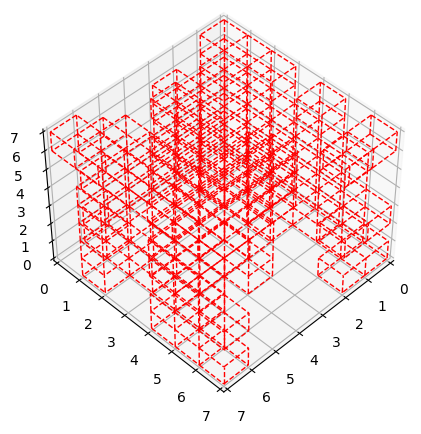

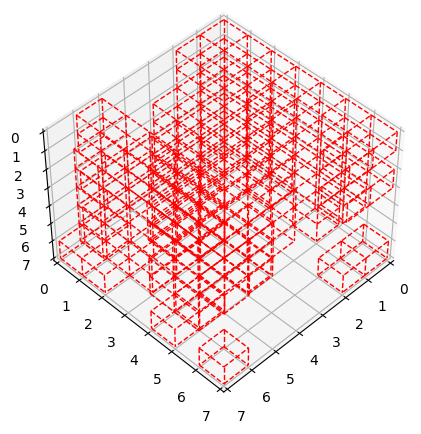

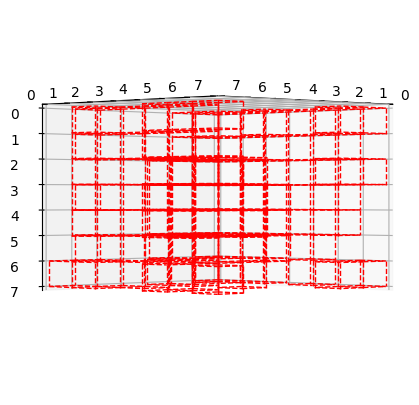

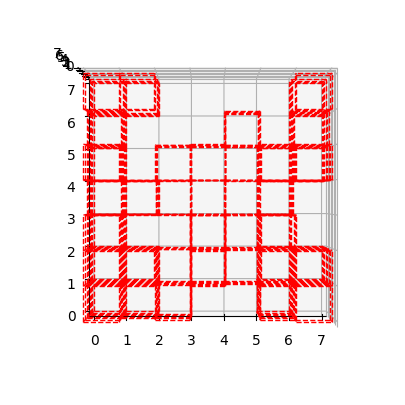

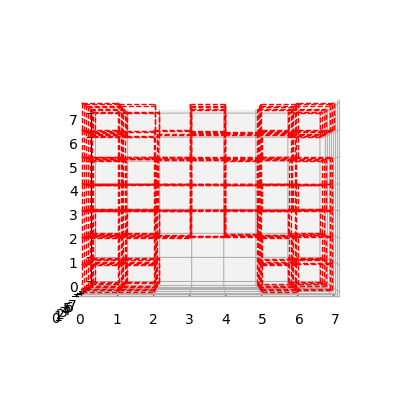

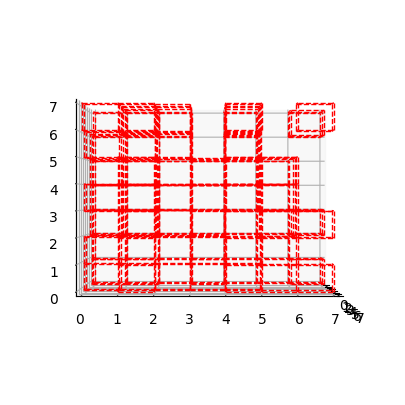

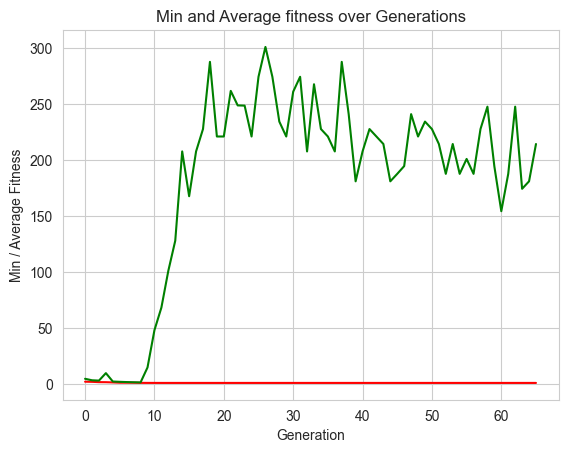

7:04:54.502589


In [30]:
startTime1 = datetime.now()
main()
print(datetime.now() - startTime1)